In [1]:
from keras.datasets import mnist
from keras.layers import Dense, Dropout, Input
from keras.models import Model,Sequential
from keras.layers.advanced_activations import LeakyReLU
from keras.optimizers import Adam
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from google.colab import drive
drive.mount('/content/gdrive')
path = 'gdrive/My Drive/Project/Practice/Result_GAN/'

Using TensorFlow backend.


Mounted at /content/gdrive


In [2]:
# Load the dataset
def load_data():
  (x_train, y_train), (_, _) = mnist.load_data()
  x_train = (x_train.astype(np.float32) - 127.5)/127.5
  x_train = x_train.reshape(60000, 784)
  return (x_train, y_train)

X_train, y_train = load_data()
print(X_train.shape, y_train.shape)

(60000, 784) (60000,)


In [3]:
def build_generator():
    model = Sequential()
    
    model.add(Dense(units=256, input_dim=100))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(units=512))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(units=1024))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dense(units=784, activation='tanh'))
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    return model

generator = build_generator()
generator.summary()






Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1024)              525312    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 1024)              0         
_____________________

In [4]:
def build_discriminator():
    model = Sequential()
    
    model.add(Dense(units=1024 ,input_dim=784))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
       
    model.add(Dense(units=512))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
       
    model.add(Dense(units=256))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.3))
      
    model.add(Dense(units=1, activation='sigmoid'))
    
    model.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    return model
  
discriminator = build_discriminator()
discriminator.summary()


Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1024)              803840    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_5 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
____

In [5]:
def build_GAN(discriminator, generator):
    discriminator.trainable=False
    GAN_input = Input(shape=(100,))
    x = generator(GAN_input)
    GAN_output= discriminator(x)
    GAN = Model(inputs=GAN_input, outputs=GAN_output)
    GAN.compile(loss='binary_crossentropy', optimizer=Adam(0.0002, 0.5))
    
    return GAN
GAN = build_GAN(discriminator, generator)
GAN.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 784)               1486352   
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 1460225   
Total params: 2,946,577
Trainable params: 1,486,352
Non-trainable params: 1,460,225
_________________________________________________________________


In [0]:
def draw_images(generator, epoch, examples=25, dim=(5,5), figsize=(10,10)):
    noise= np.random.normal(loc=0, scale=1, size=[examples, 100])
    generated_images = generator.predict(noise)
    generated_images = generated_images.reshape(25,28,28)
    plt.figure(figsize=figsize)
    for i in range(generated_images.shape[0]):
        plt.subplot(dim[0], dim[1], i+1)
        plt.imshow(generated_images[i], interpolation='nearest', cmap='Greys')
        plt.axis('off')
    plt.tight_layout()
    plt.savefig(path+'Generated_images %d.png' %epoch)

In [0]:
def train_GAN(epochs=1, batch_size=128):
    
  #Loading the data
  X_train, y_train = load_data()

  # Creating GAN
  generator= build_generator()
  discriminator= build_discriminator()
  GAN = build_GAN(discriminator, generator)

  for i in range(1, epochs+1):
    print("Epoch %d" %i)
    
    for _ in tqdm(range(batch_size)):
      # Generate fake images from random noiset
      noise= np.random.normal(0,1, (batch_size, 100))
      fake_images = generator.predict(noise)

      # Select a random batch of real images from MNIST
      real_images = X_train[np.random.randint(0, X_train.shape[0], batch_size)]

      # Labels for fake and real images           
      label_fake = np.zeros(batch_size)
      label_real = np.ones(batch_size) 

      # Concatenate fake and real images 
      X = np.concatenate([fake_images, real_images])
      y = np.concatenate([label_fake, label_real])

      # Train the discriminator
      discriminator.trainable=True
      discriminator.train_on_batch(X, y)

      # Train the generator/chained GAN model (with frozen weights in discriminator) 
      discriminator.trainable=False
      GAN.train_on_batch(noise, label_real)

    # Draw generated images every 15 epoches     
    if i == 1 or i % 10 == 0:
      draw_images(generator, i)

  0%|          | 0/128 [00:00<?, ?it/s]

Epoch 1










  4%|▍         | 5/128 [00:00<00:02, 42.70it/s]

Epoch 2


  4%|▍         | 5/128 [00:00<00:02, 43.35it/s]

Epoch 3


  4%|▍         | 5/128 [00:00<00:02, 43.01it/s]

Epoch 4


  4%|▍         | 5/128 [00:00<00:02, 44.25it/s]

Epoch 5


  4%|▍         | 5/128 [00:00<00:02, 43.43it/s]

Epoch 6


  4%|▍         | 5/128 [00:00<00:02, 44.13it/s]

Epoch 7


  4%|▍         | 5/128 [00:00<00:02, 44.31it/s]

Epoch 8


  3%|▎         | 4/128 [00:00<00:03, 39.58it/s]

Epoch 9


  4%|▍         | 5/128 [00:00<00:02, 42.25it/s]

Epoch 10


  4%|▍         | 5/128 [00:00<00:02, 42.21it/s]

Epoch 11


  4%|▍         | 5/128 [00:00<00:02, 42.22it/s]

Epoch 12


  4%|▍         | 5/128 [00:00<00:02, 41.86it/s]

Epoch 13


  4%|▍         | 5/128 [00:00<00:02, 45.55it/s]

Epoch 14


  4%|▍         | 5/128 [00:00<00:02, 44.26it/s]

Epoch 15


  4%|▍         | 5/128 [00:00<00:02, 43.56it/s]

Epoch 16


  4%|▍         | 5/128 [00:00<00:02, 42.63it/s]

Epoch 17


  4%|▍         | 5/128 [00:00<00:02, 43.37it/s]

Epoch 18


  4%|▍         | 5/128 [00:00<00:02, 44.01it/s]

Epoch 19


  4%|▍         | 5/128 [00:00<00:02, 43.58it/s]

Epoch 20


  4%|▍         | 5/128 [00:00<00:02, 42.69it/s]

Epoch 21


  4%|▍         | 5/128 [00:00<00:02, 43.49it/s]

Epoch 22


  4%|▍         | 5/128 [00:00<00:03, 40.59it/s]

Epoch 23


  4%|▍         | 5/128 [00:00<00:02, 42.19it/s]

Epoch 24


  4%|▍         | 5/128 [00:00<00:02, 43.63it/s]

Epoch 25


  4%|▍         | 5/128 [00:00<00:02, 43.97it/s]

Epoch 26


  4%|▍         | 5/128 [00:00<00:02, 42.75it/s]

Epoch 27


  4%|▍         | 5/128 [00:00<00:02, 44.40it/s]

Epoch 28


  4%|▍         | 5/128 [00:00<00:02, 44.19it/s]

Epoch 29


  4%|▍         | 5/128 [00:00<00:02, 43.51it/s]

Epoch 30


  4%|▍         | 5/128 [00:00<00:02, 41.34it/s]

Epoch 31


  4%|▍         | 5/128 [00:00<00:02, 44.19it/s]

Epoch 32


  4%|▍         | 5/128 [00:00<00:02, 43.00it/s]

Epoch 33


  4%|▍         | 5/128 [00:00<00:02, 41.96it/s]

Epoch 34


  4%|▍         | 5/128 [00:00<00:02, 42.10it/s]

Epoch 35


  4%|▍         | 5/128 [00:00<00:02, 42.98it/s]

Epoch 36


  4%|▍         | 5/128 [00:00<00:02, 43.31it/s]

Epoch 37


  4%|▍         | 5/128 [00:00<00:02, 44.18it/s]

Epoch 38


  4%|▍         | 5/128 [00:00<00:02, 43.05it/s]

Epoch 39


  4%|▍         | 5/128 [00:00<00:02, 42.01it/s]

Epoch 40


  4%|▍         | 5/128 [00:00<00:02, 42.30it/s]

Epoch 41


  4%|▍         | 5/128 [00:00<00:02, 43.47it/s]

Epoch 42


  4%|▍         | 5/128 [00:00<00:02, 44.82it/s]

Epoch 43


  4%|▍         | 5/128 [00:00<00:02, 42.66it/s]

Epoch 44


  4%|▍         | 5/128 [00:00<00:02, 42.27it/s]

Epoch 45


  4%|▍         | 5/128 [00:00<00:02, 42.88it/s]

Epoch 46


  4%|▍         | 5/128 [00:00<00:02, 44.35it/s]

Epoch 47


  4%|▍         | 5/128 [00:00<00:02, 43.44it/s]

Epoch 48


  4%|▍         | 5/128 [00:00<00:02, 42.39it/s]

Epoch 49


  4%|▍         | 5/128 [00:00<00:02, 45.04it/s]

Epoch 50


  4%|▍         | 5/128 [00:00<00:02, 41.51it/s]

Epoch 51


  4%|▍         | 5/128 [00:00<00:02, 44.40it/s]

Epoch 52


  4%|▍         | 5/128 [00:00<00:02, 43.72it/s]

Epoch 53


  4%|▍         | 5/128 [00:00<00:02, 44.21it/s]

Epoch 54


  4%|▍         | 5/128 [00:00<00:02, 44.48it/s]

Epoch 55


  4%|▍         | 5/128 [00:00<00:02, 43.73it/s]

Epoch 56


  4%|▍         | 5/128 [00:00<00:02, 43.06it/s]

Epoch 57


  4%|▍         | 5/128 [00:00<00:02, 42.56it/s]

Epoch 58


  4%|▍         | 5/128 [00:00<00:02, 43.25it/s]

Epoch 59


  4%|▍         | 5/128 [00:00<00:02, 42.95it/s]

Epoch 60


  4%|▍         | 5/128 [00:00<00:02, 41.85it/s]

Epoch 61


  4%|▍         | 5/128 [00:00<00:02, 43.47it/s]

Epoch 62


  4%|▍         | 5/128 [00:00<00:02, 43.30it/s]

Epoch 63


  4%|▍         | 5/128 [00:00<00:02, 43.77it/s]

Epoch 64


  4%|▍         | 5/128 [00:00<00:02, 43.25it/s]

Epoch 65


  4%|▍         | 5/128 [00:00<00:02, 43.34it/s]

Epoch 66


  4%|▍         | 5/128 [00:00<00:02, 41.97it/s]

Epoch 67


  4%|▍         | 5/128 [00:00<00:02, 42.80it/s]

Epoch 68


  4%|▍         | 5/128 [00:00<00:03, 40.08it/s]

Epoch 69


  4%|▍         | 5/128 [00:00<00:02, 43.87it/s]

Epoch 70


  4%|▍         | 5/128 [00:00<00:02, 43.20it/s]

Epoch 71


  4%|▍         | 5/128 [00:00<00:02, 44.27it/s]

Epoch 72


  4%|▍         | 5/128 [00:00<00:02, 44.72it/s]

Epoch 73


  3%|▎         | 4/128 [00:00<00:03, 39.86it/s]

Epoch 74


  4%|▍         | 5/128 [00:00<00:02, 43.45it/s]

Epoch 75


  4%|▍         | 5/128 [00:00<00:02, 43.75it/s]

Epoch 76


  4%|▍         | 5/128 [00:00<00:02, 42.74it/s]

Epoch 77


  4%|▍         | 5/128 [00:00<00:02, 44.27it/s]

Epoch 78


  4%|▍         | 5/128 [00:00<00:02, 42.18it/s]

Epoch 79


  4%|▍         | 5/128 [00:00<00:02, 44.26it/s]

Epoch 80


  3%|▎         | 4/128 [00:00<00:03, 39.95it/s]

Epoch 81


  4%|▍         | 5/128 [00:00<00:02, 43.99it/s]

Epoch 82


  4%|▍         | 5/128 [00:00<00:02, 44.25it/s]

Epoch 83


  4%|▍         | 5/128 [00:00<00:02, 44.23it/s]

Epoch 84


  4%|▍         | 5/128 [00:00<00:02, 42.19it/s]

Epoch 85


  4%|▍         | 5/128 [00:00<00:02, 44.31it/s]

Epoch 86


  4%|▍         | 5/128 [00:00<00:02, 42.15it/s]

Epoch 87


  4%|▍         | 5/128 [00:00<00:02, 43.88it/s]

Epoch 88


  4%|▍         | 5/128 [00:00<00:02, 44.34it/s]

Epoch 89


  4%|▍         | 5/128 [00:00<00:02, 44.66it/s]

Epoch 90


  4%|▍         | 5/128 [00:00<00:02, 41.29it/s]

Epoch 91


  4%|▍         | 5/128 [00:00<00:02, 42.12it/s]

Epoch 92


  4%|▍         | 5/128 [00:00<00:02, 44.24it/s]

Epoch 93


  4%|▍         | 5/128 [00:00<00:02, 42.76it/s]

Epoch 94


  4%|▍         | 5/128 [00:00<00:02, 42.94it/s]

Epoch 95


  4%|▍         | 5/128 [00:00<00:02, 41.73it/s]

Epoch 96


  4%|▍         | 5/128 [00:00<00:02, 44.73it/s]

Epoch 97


  4%|▍         | 5/128 [00:00<00:02, 41.78it/s]

Epoch 98


  4%|▍         | 5/128 [00:00<00:02, 45.47it/s]

Epoch 99


  3%|▎         | 4/128 [00:00<00:03, 39.87it/s]

Epoch 100


  4%|▍         | 5/128 [00:00<00:02, 42.89it/s]

Epoch 101


  4%|▍         | 5/128 [00:00<00:02, 42.24it/s]

Epoch 102


  4%|▍         | 5/128 [00:00<00:02, 44.99it/s]

Epoch 103


  4%|▍         | 5/128 [00:00<00:02, 42.97it/s]

Epoch 104


  4%|▍         | 5/128 [00:00<00:02, 42.81it/s]

Epoch 105


  4%|▍         | 5/128 [00:00<00:02, 43.59it/s]

Epoch 106


  4%|▍         | 5/128 [00:00<00:02, 44.79it/s]

Epoch 107


  4%|▍         | 5/128 [00:00<00:02, 44.57it/s]

Epoch 108


  4%|▍         | 5/128 [00:00<00:03, 40.65it/s]

Epoch 109


  4%|▍         | 5/128 [00:00<00:02, 41.86it/s]

Epoch 110


  4%|▍         | 5/128 [00:00<00:02, 42.52it/s]

Epoch 111


  4%|▍         | 5/128 [00:00<00:02, 44.34it/s]

Epoch 112


  4%|▍         | 5/128 [00:00<00:02, 43.83it/s]

Epoch 113


  4%|▍         | 5/128 [00:00<00:02, 44.13it/s]

Epoch 114


  4%|▍         | 5/128 [00:00<00:02, 41.66it/s]

Epoch 115


  4%|▍         | 5/128 [00:00<00:02, 41.53it/s]

Epoch 116


  4%|▍         | 5/128 [00:00<00:02, 42.42it/s]

Epoch 117


  4%|▍         | 5/128 [00:00<00:02, 43.55it/s]

Epoch 118


  4%|▍         | 5/128 [00:00<00:02, 43.47it/s]

Epoch 119


  4%|▍         | 5/128 [00:00<00:02, 42.10it/s]

Epoch 120


  4%|▍         | 5/128 [00:00<00:02, 43.01it/s]

Epoch 121


  4%|▍         | 5/128 [00:00<00:02, 43.59it/s]

Epoch 122


  4%|▍         | 5/128 [00:00<00:02, 42.84it/s]

Epoch 123


  4%|▍         | 5/128 [00:00<00:02, 43.56it/s]

Epoch 124


  4%|▍         | 5/128 [00:00<00:02, 42.29it/s]

Epoch 125


  4%|▍         | 5/128 [00:00<00:02, 44.18it/s]

Epoch 126


  4%|▍         | 5/128 [00:00<00:02, 44.33it/s]

Epoch 127


  4%|▍         | 5/128 [00:00<00:02, 44.55it/s]

Epoch 128


  4%|▍         | 5/128 [00:00<00:02, 43.83it/s]

Epoch 129


  4%|▍         | 5/128 [00:00<00:02, 44.11it/s]

Epoch 130


  4%|▍         | 5/128 [00:00<00:02, 42.73it/s]

Epoch 131


  4%|▍         | 5/128 [00:00<00:02, 43.80it/s]

Epoch 132


  4%|▍         | 5/128 [00:00<00:02, 43.89it/s]

Epoch 133


  4%|▍         | 5/128 [00:00<00:02, 44.53it/s]

Epoch 134


  4%|▍         | 5/128 [00:00<00:02, 42.57it/s]

Epoch 135


  4%|▍         | 5/128 [00:00<00:02, 42.83it/s]

Epoch 136


  4%|▍         | 5/128 [00:00<00:02, 43.06it/s]

Epoch 137


  4%|▍         | 5/128 [00:00<00:02, 44.85it/s]

Epoch 138


  4%|▍         | 5/128 [00:00<00:02, 43.81it/s]

Epoch 139


  4%|▍         | 5/128 [00:00<00:02, 44.58it/s]

Epoch 140


  3%|▎         | 4/128 [00:00<00:03, 39.14it/s]

Epoch 141


  4%|▍         | 5/128 [00:00<00:02, 44.73it/s]

Epoch 142


  4%|▍         | 5/128 [00:00<00:02, 43.58it/s]

Epoch 143


  4%|▍         | 5/128 [00:00<00:02, 42.76it/s]

Epoch 144


  4%|▍         | 5/128 [00:00<00:02, 44.06it/s]

Epoch 145


  4%|▍         | 5/128 [00:00<00:02, 44.22it/s]

Epoch 146


  4%|▍         | 5/128 [00:00<00:02, 42.66it/s]

Epoch 147


  4%|▍         | 5/128 [00:00<00:02, 43.02it/s]

Epoch 148


  4%|▍         | 5/128 [00:00<00:02, 42.84it/s]

Epoch 149


  4%|▍         | 5/128 [00:00<00:02, 42.85it/s]

Epoch 150


  4%|▍         | 5/128 [00:00<00:03, 40.81it/s]

Epoch 151


  4%|▍         | 5/128 [00:00<00:02, 42.80it/s]

Epoch 152


  4%|▍         | 5/128 [00:00<00:02, 45.08it/s]

Epoch 153


  4%|▍         | 5/128 [00:00<00:02, 43.98it/s]

Epoch 154


  4%|▍         | 5/128 [00:00<00:02, 45.09it/s]

Epoch 155


  4%|▍         | 5/128 [00:00<00:02, 41.41it/s]

Epoch 156


  4%|▍         | 5/128 [00:00<00:02, 44.60it/s]

Epoch 157


  4%|▍         | 5/128 [00:00<00:02, 42.99it/s]

Epoch 158


  3%|▎         | 4/128 [00:00<00:03, 39.88it/s]

Epoch 159


  4%|▍         | 5/128 [00:00<00:02, 41.93it/s]

Epoch 160


  4%|▍         | 5/128 [00:00<00:02, 43.14it/s]

Epoch 161


  4%|▍         | 5/128 [00:00<00:02, 42.85it/s]

Epoch 162


  4%|▍         | 5/128 [00:00<00:02, 43.46it/s]

Epoch 163


  4%|▍         | 5/128 [00:00<00:02, 43.38it/s]

Epoch 164


  4%|▍         | 5/128 [00:00<00:02, 44.28it/s]

Epoch 165


  4%|▍         | 5/128 [00:00<00:02, 43.52it/s]

Epoch 166


  4%|▍         | 5/128 [00:00<00:02, 41.23it/s]

Epoch 167


  4%|▍         | 5/128 [00:00<00:02, 41.03it/s]

Epoch 168


  4%|▍         | 5/128 [00:00<00:02, 42.34it/s]

Epoch 169


  4%|▍         | 5/128 [00:00<00:02, 42.16it/s]

Epoch 170


  4%|▍         | 5/128 [00:00<00:02, 43.72it/s]

Epoch 171


  4%|▍         | 5/128 [00:00<00:03, 40.29it/s]

Epoch 172


  4%|▍         | 5/128 [00:00<00:02, 42.71it/s]

Epoch 173


  4%|▍         | 5/128 [00:00<00:02, 43.61it/s]

Epoch 174


  4%|▍         | 5/128 [00:00<00:02, 43.02it/s]

Epoch 175


  4%|▍         | 5/128 [00:00<00:02, 44.29it/s]

Epoch 176


  4%|▍         | 5/128 [00:00<00:02, 43.76it/s]

Epoch 177


  4%|▍         | 5/128 [00:00<00:02, 41.76it/s]

Epoch 178


  4%|▍         | 5/128 [00:00<00:02, 44.53it/s]

Epoch 179


  4%|▍         | 5/128 [00:00<00:02, 43.46it/s]

Epoch 180


  4%|▍         | 5/128 [00:00<00:02, 42.28it/s]

Epoch 181


  4%|▍         | 5/128 [00:00<00:02, 43.05it/s]

Epoch 182


  4%|▍         | 5/128 [00:00<00:02, 44.60it/s]

Epoch 183


  4%|▍         | 5/128 [00:00<00:02, 44.70it/s]

Epoch 184


  4%|▍         | 5/128 [00:00<00:02, 42.27it/s]

Epoch 185


  4%|▍         | 5/128 [00:00<00:02, 44.29it/s]

Epoch 186


  4%|▍         | 5/128 [00:00<00:02, 44.24it/s]

Epoch 187


  4%|▍         | 5/128 [00:00<00:02, 41.85it/s]

Epoch 188


  3%|▎         | 4/128 [00:00<00:03, 39.85it/s]

Epoch 189


  4%|▍         | 5/128 [00:00<00:02, 42.88it/s]

Epoch 190


  4%|▍         | 5/128 [00:00<00:02, 41.79it/s]

Epoch 191


  4%|▍         | 5/128 [00:00<00:02, 42.58it/s]

Epoch 192


  4%|▍         | 5/128 [00:00<00:02, 42.77it/s]

Epoch 193


  4%|▍         | 5/128 [00:00<00:02, 44.48it/s]

Epoch 194


  4%|▍         | 5/128 [00:00<00:02, 44.13it/s]

Epoch 195


  4%|▍         | 5/128 [00:00<00:02, 44.11it/s]

Epoch 196


  4%|▍         | 5/128 [00:00<00:02, 42.41it/s]

Epoch 197


  4%|▍         | 5/128 [00:00<00:02, 44.40it/s]

Epoch 198


  4%|▍         | 5/128 [00:00<00:02, 42.70it/s]

Epoch 199


  4%|▍         | 5/128 [00:00<00:02, 44.19it/s]

Epoch 200


100%|██████████| 128/128 [00:02<00:00, 43.15it/s]
/usr/local/lib/python3.6/dist-packages/matplotlib/pyplot.py:514: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)
  4%|▍         | 5/128 [00:00<00:02, 43.73it/s]

Epoch 201


  4%|▍         | 5/128 [00:00<00:02, 44.44it/s]

Epoch 202


  4%|▍         | 5/128 [00:00<00:02, 41.16it/s]

Epoch 203


  4%|▍         | 5/128 [00:00<00:02, 42.69it/s]

Epoch 204


  4%|▍         | 5/128 [00:00<00:02, 42.82it/s]

Epoch 205


  4%|▍         | 5/128 [00:00<00:02, 43.21it/s]

Epoch 206


  4%|▍         | 5/128 [00:00<00:02, 43.93it/s]

Epoch 207


  4%|▍         | 5/128 [00:00<00:02, 44.65it/s]

Epoch 208


  4%|▍         | 5/128 [00:00<00:02, 44.47it/s]

Epoch 209


  4%|▍         | 5/128 [00:00<00:02, 43.51it/s]

Epoch 210


  4%|▍         | 5/128 [00:00<00:02, 42.74it/s]

Epoch 211


  4%|▍         | 5/128 [00:00<00:02, 43.54it/s]

Epoch 212


  4%|▍         | 5/128 [00:00<00:02, 41.32it/s]

Epoch 213


  4%|▍         | 5/128 [00:00<00:02, 42.67it/s]

Epoch 214


  4%|▍         | 5/128 [00:00<00:02, 42.04it/s]

Epoch 215


  4%|▍         | 5/128 [00:00<00:02, 42.72it/s]

Epoch 216


  4%|▍         | 5/128 [00:00<00:02, 42.56it/s]

Epoch 217


  4%|▍         | 5/128 [00:00<00:02, 45.01it/s]

Epoch 218


  4%|▍         | 5/128 [00:00<00:02, 42.59it/s]

Epoch 219


  4%|▍         | 5/128 [00:00<00:02, 43.87it/s]

Epoch 220


  4%|▍         | 5/128 [00:00<00:02, 41.47it/s]

Epoch 221


  4%|▍         | 5/128 [00:00<00:02, 44.42it/s]

Epoch 222


  4%|▍         | 5/128 [00:00<00:02, 42.68it/s]

Epoch 223


  4%|▍         | 5/128 [00:00<00:02, 43.69it/s]

Epoch 224


  4%|▍         | 5/128 [00:00<00:02, 43.98it/s]

Epoch 225


  4%|▍         | 5/128 [00:00<00:02, 42.79it/s]

Epoch 226


  4%|▍         | 5/128 [00:00<00:02, 44.91it/s]

Epoch 227


  4%|▍         | 5/128 [00:00<00:02, 41.92it/s]

Epoch 228


  4%|▍         | 5/128 [00:00<00:02, 44.44it/s]

Epoch 229


  4%|▍         | 5/128 [00:00<00:02, 42.58it/s]

Epoch 230


  4%|▍         | 5/128 [00:00<00:02, 43.51it/s]

Epoch 231


  4%|▍         | 5/128 [00:00<00:02, 43.24it/s]

Epoch 232


  4%|▍         | 5/128 [00:00<00:02, 43.39it/s]

Epoch 233


  4%|▍         | 5/128 [00:00<00:02, 45.31it/s]

Epoch 234


  4%|▍         | 5/128 [00:00<00:02, 44.71it/s]

Epoch 235


  4%|▍         | 5/128 [00:00<00:02, 45.49it/s]

Epoch 236


  4%|▍         | 5/128 [00:00<00:02, 43.03it/s]

Epoch 237


  4%|▍         | 5/128 [00:00<00:02, 44.53it/s]

Epoch 238


  4%|▍         | 5/128 [00:00<00:02, 43.43it/s]

Epoch 239


  4%|▍         | 5/128 [00:00<00:02, 44.17it/s]

Epoch 240


  4%|▍         | 5/128 [00:00<00:02, 42.06it/s]

Epoch 241


  4%|▍         | 5/128 [00:00<00:02, 42.77it/s]

Epoch 242


  4%|▍         | 5/128 [00:00<00:02, 44.32it/s]

Epoch 243


  4%|▍         | 5/128 [00:00<00:02, 45.21it/s]

Epoch 244


  4%|▍         | 5/128 [00:00<00:02, 44.12it/s]

Epoch 245


  4%|▍         | 5/128 [00:00<00:02, 42.92it/s]

Epoch 246


  4%|▍         | 5/128 [00:00<00:02, 44.37it/s]

Epoch 247


  4%|▍         | 5/128 [00:00<00:02, 44.30it/s]

Epoch 248


  4%|▍         | 5/128 [00:00<00:02, 44.43it/s]

Epoch 249


  4%|▍         | 5/128 [00:00<00:02, 42.54it/s]

Epoch 250


  4%|▍         | 5/128 [00:00<00:02, 43.86it/s]

Epoch 251


  4%|▍         | 5/128 [00:00<00:02, 44.60it/s]

Epoch 252


  4%|▍         | 5/128 [00:00<00:02, 44.01it/s]

Epoch 253


  4%|▍         | 5/128 [00:00<00:02, 44.32it/s]

Epoch 254


  4%|▍         | 5/128 [00:00<00:02, 42.94it/s]

Epoch 255


  4%|▍         | 5/128 [00:00<00:02, 44.94it/s]

Epoch 256


  4%|▍         | 5/128 [00:00<00:02, 43.62it/s]

Epoch 257


  4%|▍         | 5/128 [00:00<00:02, 44.47it/s]

Epoch 258


  4%|▍         | 5/128 [00:00<00:02, 44.28it/s]

Epoch 259


  4%|▍         | 5/128 [00:00<00:02, 43.95it/s]

Epoch 260


  4%|▍         | 5/128 [00:00<00:02, 44.23it/s]

Epoch 261


  4%|▍         | 5/128 [00:00<00:02, 43.76it/s]

Epoch 262


  4%|▍         | 5/128 [00:00<00:02, 45.02it/s]

Epoch 263


  4%|▍         | 5/128 [00:00<00:02, 45.66it/s]

Epoch 264


  4%|▍         | 5/128 [00:00<00:02, 45.42it/s]

Epoch 265


  4%|▍         | 5/128 [00:00<00:02, 42.81it/s]

Epoch 266


  4%|▍         | 5/128 [00:00<00:02, 43.43it/s]

Epoch 267


  4%|▍         | 5/128 [00:00<00:02, 44.45it/s]

Epoch 268


  4%|▍         | 5/128 [00:00<00:02, 44.89it/s]

Epoch 269


  4%|▍         | 5/128 [00:00<00:02, 44.51it/s]

Epoch 270


  4%|▍         | 5/128 [00:00<00:02, 42.98it/s]

Epoch 271


  4%|▍         | 5/128 [00:00<00:02, 44.23it/s]

Epoch 272


  4%|▍         | 5/128 [00:00<00:02, 41.64it/s]

Epoch 273


  4%|▍         | 5/128 [00:00<00:02, 44.15it/s]

Epoch 274


  4%|▍         | 5/128 [00:00<00:02, 43.47it/s]

Epoch 275


  4%|▍         | 5/128 [00:00<00:02, 42.78it/s]

Epoch 276


  4%|▍         | 5/128 [00:00<00:02, 42.55it/s]

Epoch 277


  4%|▍         | 5/128 [00:00<00:02, 45.49it/s]

Epoch 278


  4%|▍         | 5/128 [00:00<00:02, 45.81it/s]

Epoch 279


  4%|▍         | 5/128 [00:00<00:02, 43.04it/s]

Epoch 280


  4%|▍         | 5/128 [00:00<00:02, 42.62it/s]

Epoch 281


  4%|▍         | 5/128 [00:00<00:02, 46.42it/s]

Epoch 282


  4%|▍         | 5/128 [00:00<00:02, 43.46it/s]

Epoch 283


  4%|▍         | 5/128 [00:00<00:02, 43.94it/s]

Epoch 284


  4%|▍         | 5/128 [00:00<00:02, 41.67it/s]

Epoch 285


  4%|▍         | 5/128 [00:00<00:02, 42.35it/s]

Epoch 286


  4%|▍         | 5/128 [00:00<00:02, 43.98it/s]

Epoch 287


  4%|▍         | 5/128 [00:00<00:02, 44.50it/s]

Epoch 288


  4%|▍         | 5/128 [00:00<00:02, 42.54it/s]

Epoch 289


  4%|▍         | 5/128 [00:00<00:02, 44.17it/s]

Epoch 290


  4%|▍         | 5/128 [00:00<00:02, 44.09it/s]

Epoch 291


  4%|▍         | 5/128 [00:00<00:02, 43.52it/s]

Epoch 292


  4%|▍         | 5/128 [00:00<00:02, 43.13it/s]

Epoch 293


  4%|▍         | 5/128 [00:00<00:02, 44.82it/s]

Epoch 294


  4%|▍         | 5/128 [00:00<00:02, 44.33it/s]

Epoch 295


  4%|▍         | 5/128 [00:00<00:02, 44.25it/s]

Epoch 296


  4%|▍         | 5/128 [00:00<00:02, 43.80it/s]

Epoch 297


  4%|▍         | 5/128 [00:00<00:02, 45.37it/s]

Epoch 298


  4%|▍         | 5/128 [00:00<00:02, 45.17it/s]

Epoch 299


  4%|▍         | 5/128 [00:00<00:02, 41.32it/s]

Epoch 300


  4%|▍         | 5/128 [00:00<00:02, 44.37it/s]

Epoch 301


  4%|▍         | 5/128 [00:00<00:02, 43.04it/s]

Epoch 302


  4%|▍         | 5/128 [00:00<00:02, 45.03it/s]

Epoch 303


  4%|▍         | 5/128 [00:00<00:02, 42.67it/s]

Epoch 304


  4%|▍         | 5/128 [00:00<00:02, 41.98it/s]

Epoch 305


  4%|▍         | 5/128 [00:00<00:02, 43.94it/s]

Epoch 306


  4%|▍         | 5/128 [00:00<00:02, 45.03it/s]

Epoch 307


  4%|▍         | 5/128 [00:00<00:02, 45.46it/s]

Epoch 308


  4%|▍         | 5/128 [00:00<00:02, 43.79it/s]

Epoch 309


  4%|▍         | 5/128 [00:00<00:02, 44.96it/s]

Epoch 310


  4%|▍         | 5/128 [00:00<00:02, 42.62it/s]

Epoch 311


  4%|▍         | 5/128 [00:00<00:02, 44.24it/s]

Epoch 312


  4%|▍         | 5/128 [00:00<00:02, 42.11it/s]

Epoch 313


  4%|▍         | 5/128 [00:00<00:02, 42.39it/s]

Epoch 314


  4%|▍         | 5/128 [00:00<00:02, 41.76it/s]

Epoch 315


  4%|▍         | 5/128 [00:00<00:02, 45.19it/s]

Epoch 316


  4%|▍         | 5/128 [00:00<00:02, 44.28it/s]

Epoch 317


  4%|▍         | 5/128 [00:00<00:02, 43.42it/s]

Epoch 318


  4%|▍         | 5/128 [00:00<00:02, 43.92it/s]

Epoch 319


  4%|▍         | 5/128 [00:00<00:02, 44.46it/s]

Epoch 320


  4%|▍         | 5/128 [00:00<00:02, 43.37it/s]

Epoch 321


  4%|▍         | 5/128 [00:00<00:02, 45.65it/s]

Epoch 322


  4%|▍         | 5/128 [00:00<00:02, 42.99it/s]

Epoch 323


  4%|▍         | 5/128 [00:00<00:02, 45.21it/s]

Epoch 324


  4%|▍         | 5/128 [00:00<00:02, 43.41it/s]

Epoch 325


  4%|▍         | 5/128 [00:00<00:02, 43.34it/s]

Epoch 326


  4%|▍         | 5/128 [00:00<00:02, 42.19it/s]

Epoch 327


  4%|▍         | 5/128 [00:00<00:02, 43.76it/s]

Epoch 328


  4%|▍         | 5/128 [00:00<00:02, 45.04it/s]

Epoch 329


  4%|▍         | 5/128 [00:00<00:02, 44.46it/s]

Epoch 330


  4%|▍         | 5/128 [00:00<00:02, 43.93it/s]

Epoch 331


  4%|▍         | 5/128 [00:00<00:02, 44.14it/s]

Epoch 332


  4%|▍         | 5/128 [00:00<00:02, 44.83it/s]

Epoch 333


  4%|▍         | 5/128 [00:00<00:02, 44.16it/s]

Epoch 334


  4%|▍         | 5/128 [00:00<00:02, 45.26it/s]

Epoch 335


  4%|▍         | 5/128 [00:00<00:02, 44.43it/s]

Epoch 336


  4%|▍         | 5/128 [00:00<00:02, 43.91it/s]

Epoch 337


  4%|▍         | 5/128 [00:00<00:02, 43.74it/s]

Epoch 338


  4%|▍         | 5/128 [00:00<00:02, 42.59it/s]

Epoch 339


  4%|▍         | 5/128 [00:00<00:02, 45.80it/s]

Epoch 340


  3%|▎         | 4/128 [00:00<00:03, 37.09it/s]

Epoch 341


  4%|▍         | 5/128 [00:00<00:02, 46.05it/s]

Epoch 342


  4%|▍         | 5/128 [00:00<00:02, 45.10it/s]

Epoch 343


  4%|▍         | 5/128 [00:00<00:02, 44.10it/s]

Epoch 344


  4%|▍         | 5/128 [00:00<00:02, 45.36it/s]

Epoch 345


  4%|▍         | 5/128 [00:00<00:02, 44.25it/s]

Epoch 346


  4%|▍         | 5/128 [00:00<00:02, 45.87it/s]

Epoch 347


  4%|▍         | 5/128 [00:00<00:02, 44.93it/s]

Epoch 348


  4%|▍         | 5/128 [00:00<00:02, 43.90it/s]

Epoch 349


  3%|▎         | 4/128 [00:00<00:03, 37.56it/s]

Epoch 350


  4%|▍         | 5/128 [00:00<00:02, 42.39it/s]

Epoch 351


  4%|▍         | 5/128 [00:00<00:02, 44.92it/s]

Epoch 352


  4%|▍         | 5/128 [00:00<00:02, 43.30it/s]

Epoch 353


  4%|▍         | 5/128 [00:00<00:02, 42.16it/s]

Epoch 354


  4%|▍         | 5/128 [00:00<00:02, 44.18it/s]

Epoch 355


  4%|▍         | 5/128 [00:00<00:02, 44.52it/s]

Epoch 356


  4%|▍         | 5/128 [00:00<00:02, 43.87it/s]

Epoch 357


  4%|▍         | 5/128 [00:00<00:02, 45.15it/s]

Epoch 358


  4%|▍         | 5/128 [00:00<00:02, 44.25it/s]

Epoch 359


  4%|▍         | 5/128 [00:00<00:02, 45.08it/s]

Epoch 360


  4%|▍         | 5/128 [00:00<00:02, 42.82it/s]

Epoch 361


  4%|▍         | 5/128 [00:00<00:02, 43.51it/s]

Epoch 362


  4%|▍         | 5/128 [00:00<00:02, 44.08it/s]

Epoch 363


  4%|▍         | 5/128 [00:00<00:02, 45.10it/s]

Epoch 364


  4%|▍         | 5/128 [00:00<00:02, 44.38it/s]

Epoch 365


  4%|▍         | 5/128 [00:00<00:02, 43.46it/s]

Epoch 366


  4%|▍         | 5/128 [00:00<00:02, 44.05it/s]

Epoch 367


  4%|▍         | 5/128 [00:00<00:02, 43.70it/s]

Epoch 368


  4%|▍         | 5/128 [00:00<00:02, 42.84it/s]

Epoch 369


  4%|▍         | 5/128 [00:00<00:02, 42.66it/s]

Epoch 370


  4%|▍         | 5/128 [00:00<00:02, 41.80it/s]

Epoch 371


  4%|▍         | 5/128 [00:00<00:02, 45.60it/s]

Epoch 372


  4%|▍         | 5/128 [00:00<00:02, 43.66it/s]

Epoch 373


  4%|▍         | 5/128 [00:00<00:02, 43.91it/s]

Epoch 374


  4%|▍         | 5/128 [00:00<00:02, 44.66it/s]

Epoch 375


  4%|▍         | 5/128 [00:00<00:02, 43.34it/s]

Epoch 376


  4%|▍         | 5/128 [00:00<00:02, 42.58it/s]

Epoch 377


  4%|▍         | 5/128 [00:00<00:02, 43.24it/s]

Epoch 378


  4%|▍         | 5/128 [00:00<00:02, 44.65it/s]

Epoch 379


  4%|▍         | 5/128 [00:00<00:02, 41.20it/s]

Epoch 380


  3%|▎         | 4/128 [00:00<00:03, 39.91it/s]

Epoch 381


  4%|▍         | 5/128 [00:00<00:02, 44.39it/s]

Epoch 382


  4%|▍         | 5/128 [00:00<00:02, 43.27it/s]

Epoch 383


  4%|▍         | 5/128 [00:00<00:02, 43.43it/s]

Epoch 384


  4%|▍         | 5/128 [00:00<00:02, 43.36it/s]

Epoch 385


  4%|▍         | 5/128 [00:00<00:02, 44.30it/s]

Epoch 386


  4%|▍         | 5/128 [00:00<00:02, 44.05it/s]

Epoch 387


  4%|▍         | 5/128 [00:00<00:02, 43.54it/s]

Epoch 388


  4%|▍         | 5/128 [00:00<00:03, 40.89it/s]

Epoch 389


  4%|▍         | 5/128 [00:00<00:02, 44.97it/s]

Epoch 390


  3%|▎         | 4/128 [00:00<00:03, 39.96it/s]

Epoch 391


  4%|▍         | 5/128 [00:00<00:02, 41.39it/s]

Epoch 392


  4%|▍         | 5/128 [00:00<00:02, 43.20it/s]

Epoch 393


  4%|▍         | 5/128 [00:00<00:02, 45.26it/s]

Epoch 394


  4%|▍         | 5/128 [00:00<00:02, 44.75it/s]

Epoch 395


  4%|▍         | 5/128 [00:00<00:02, 44.42it/s]

Epoch 396


  4%|▍         | 5/128 [00:00<00:02, 43.23it/s]

Epoch 397


  4%|▍         | 5/128 [00:00<00:02, 45.23it/s]

Epoch 398


  4%|▍         | 5/128 [00:00<00:02, 44.17it/s]

Epoch 399


  4%|▍         | 5/128 [00:00<00:02, 44.23it/s]

Epoch 400


100%|██████████| 128/128 [00:02<00:00, 43.49it/s]


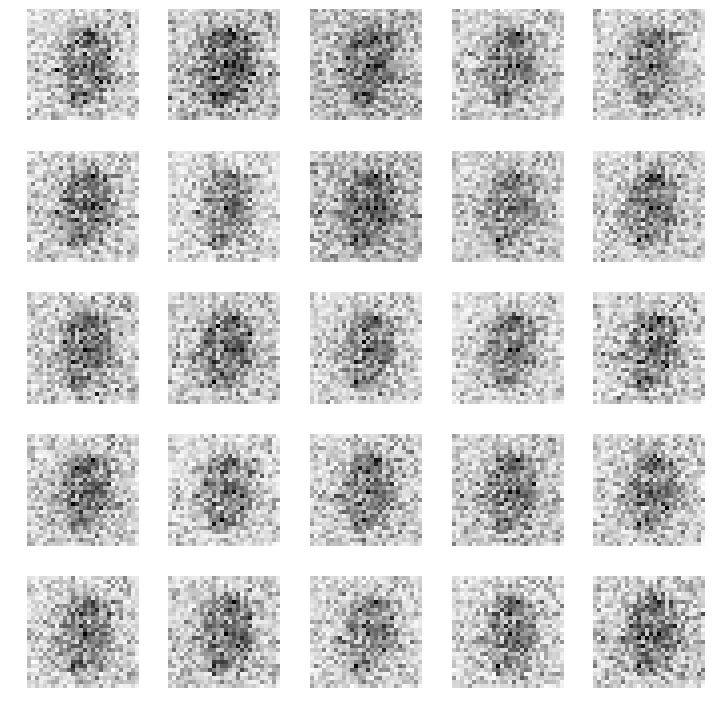

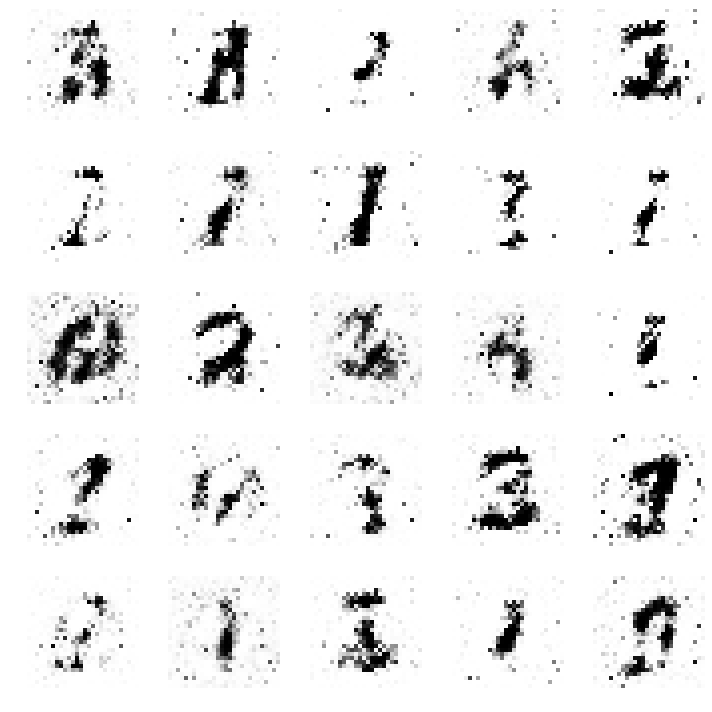

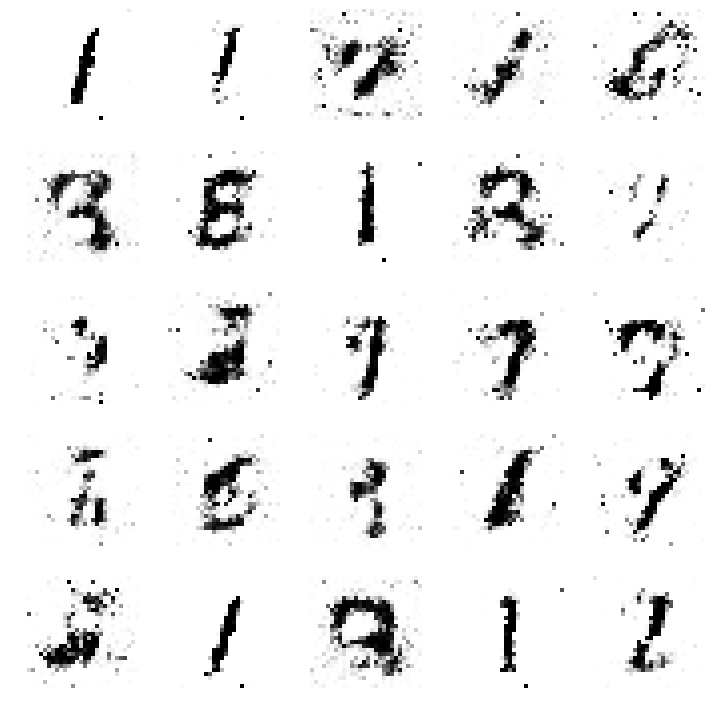

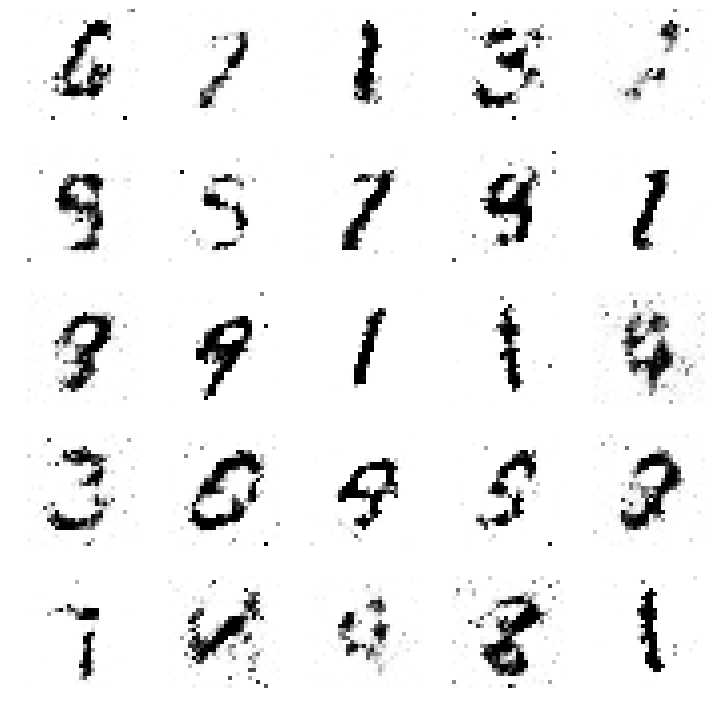

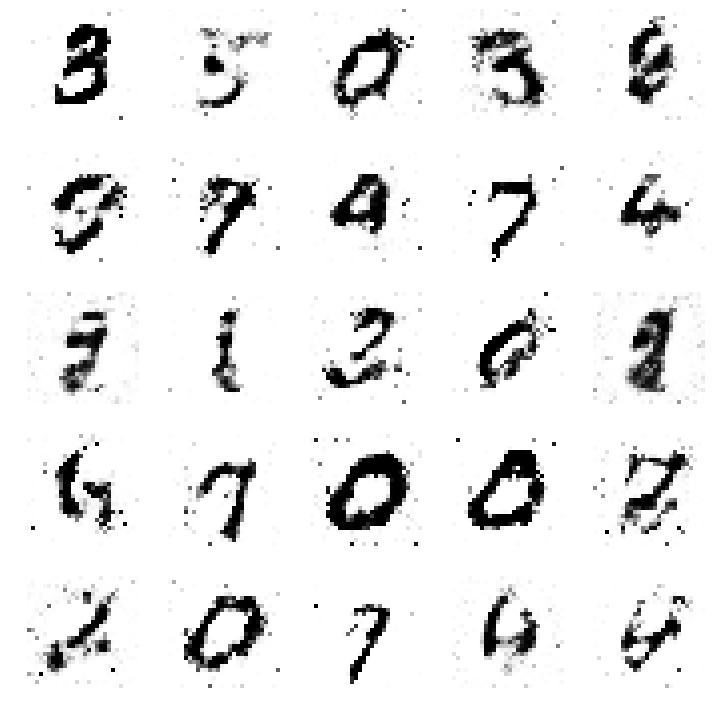

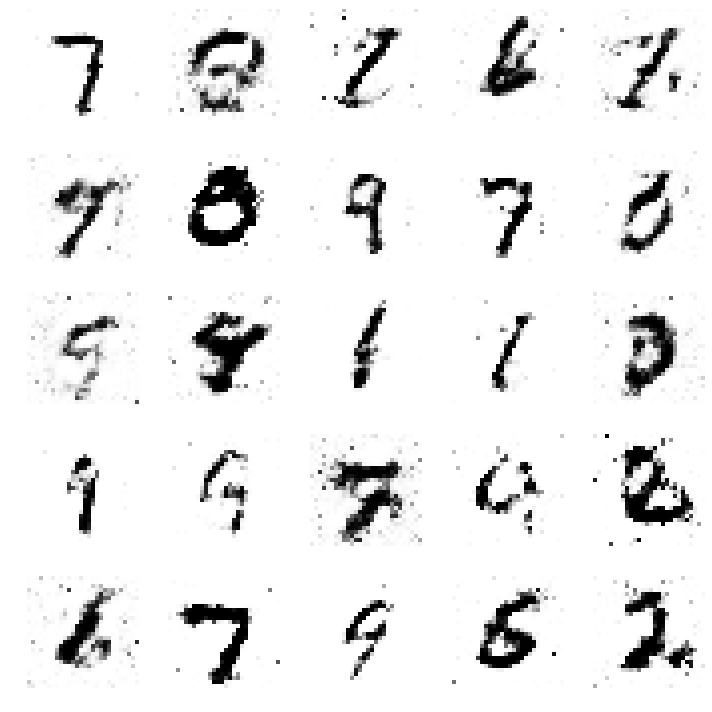

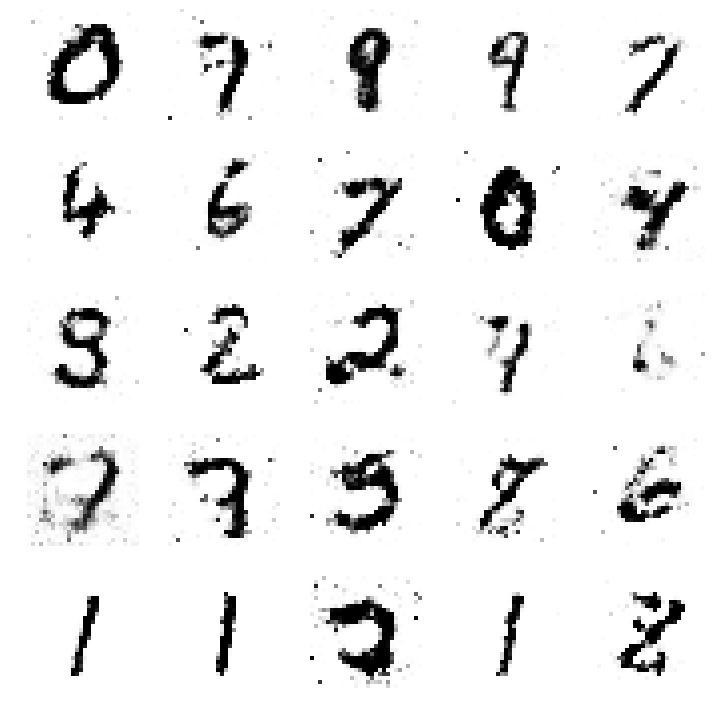

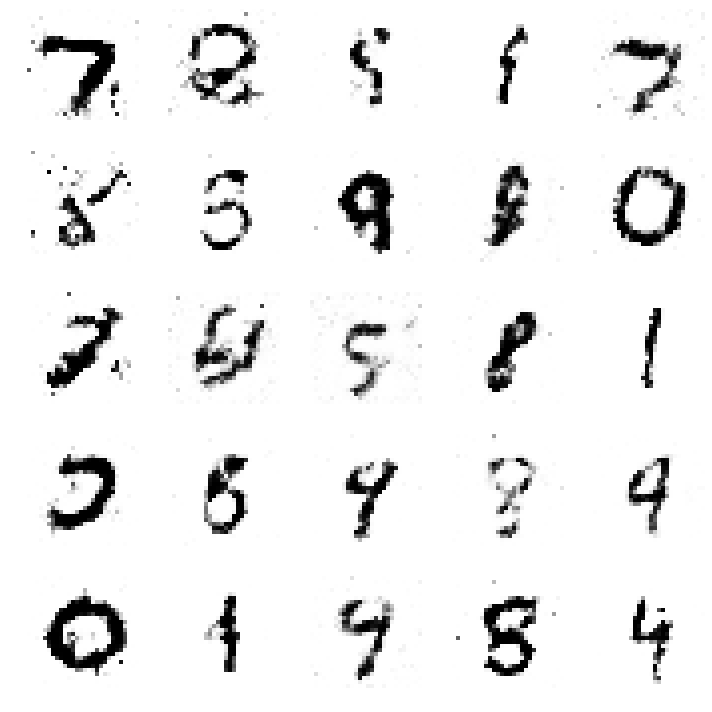

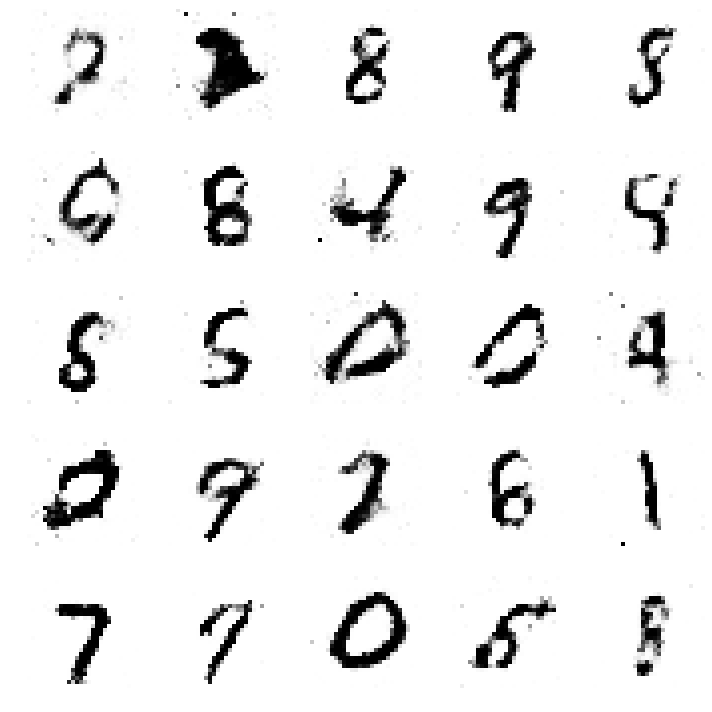

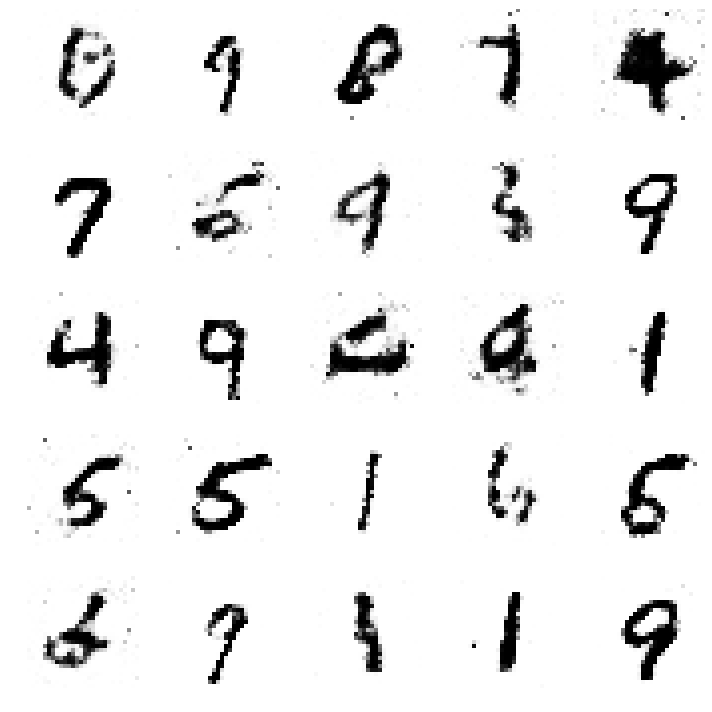

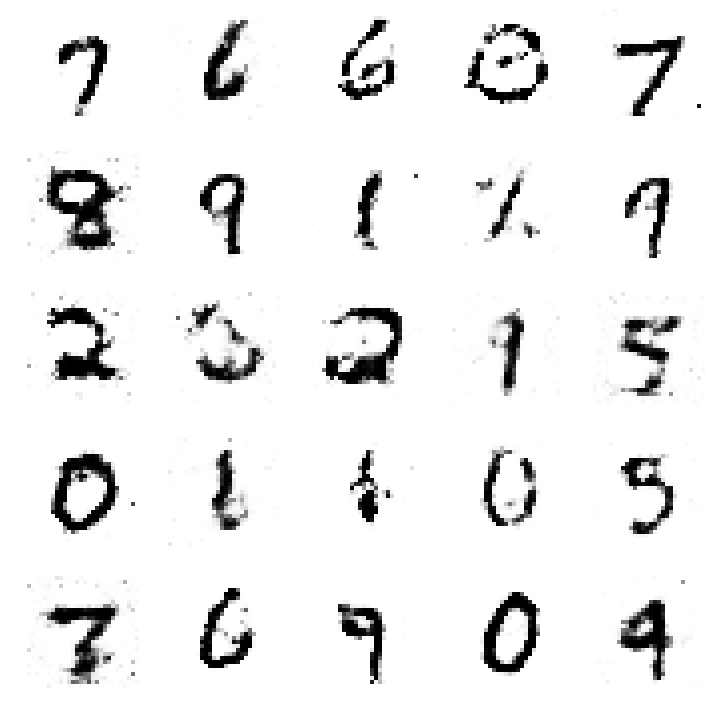

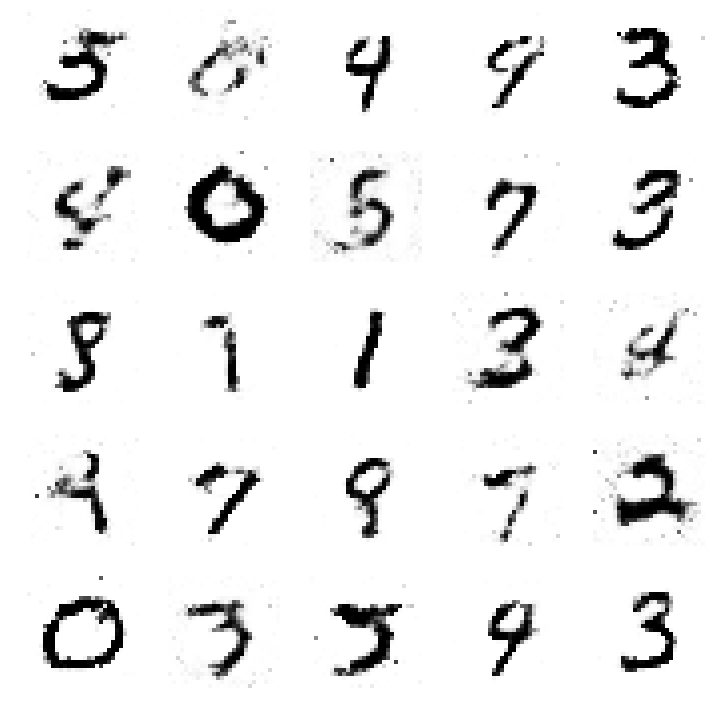

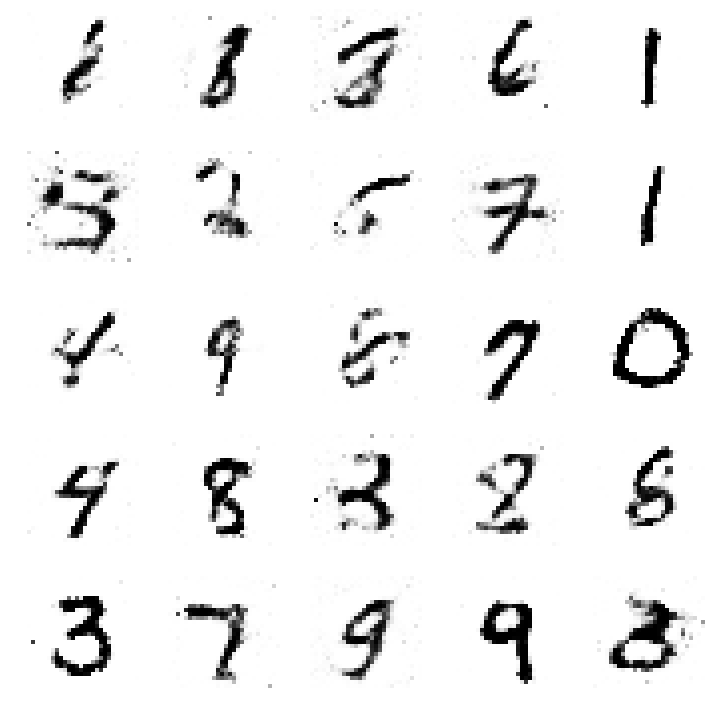

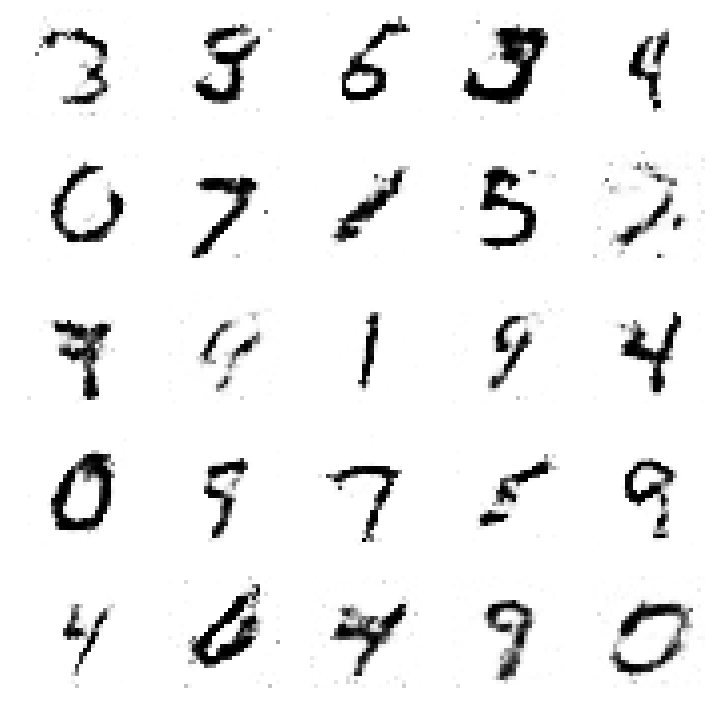

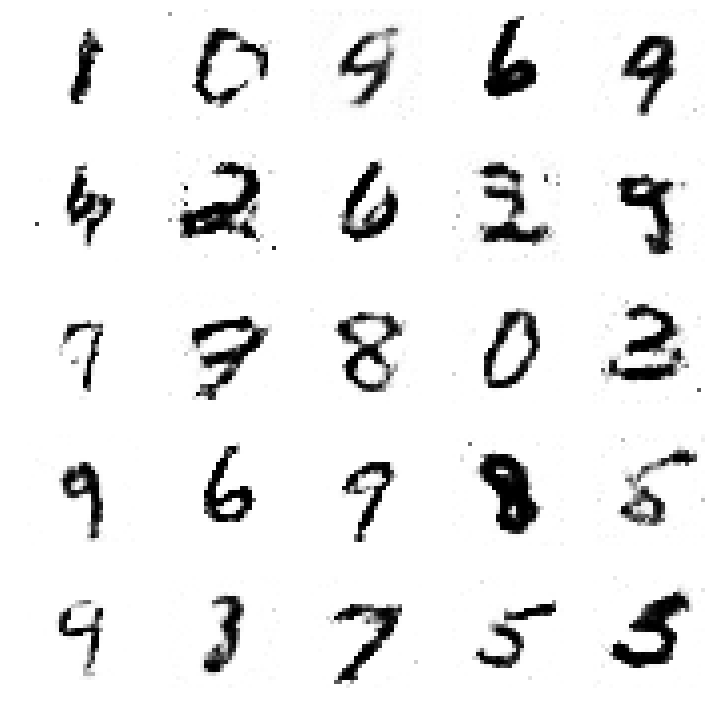

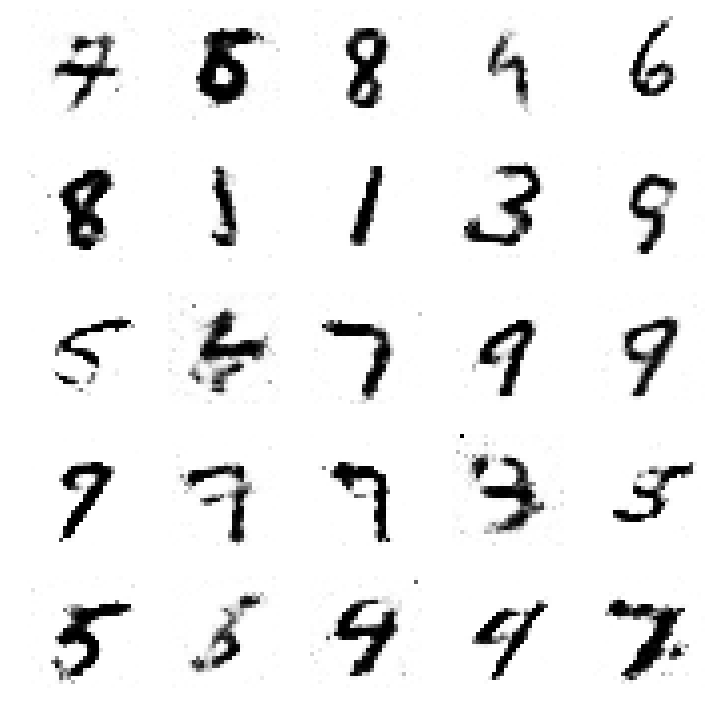

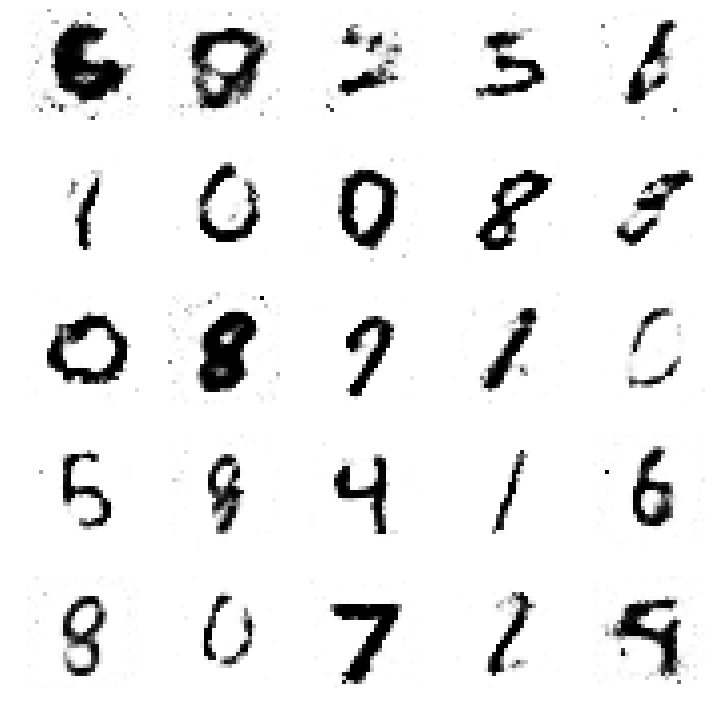

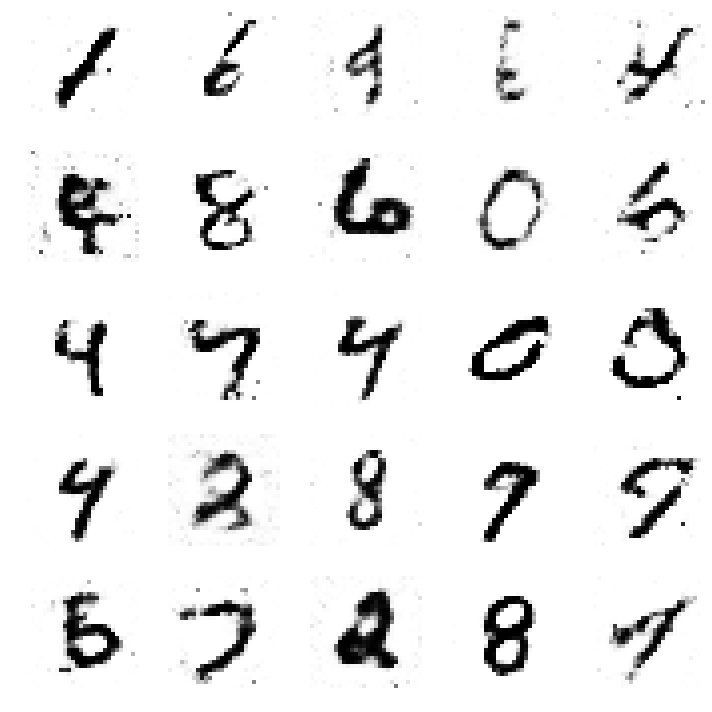

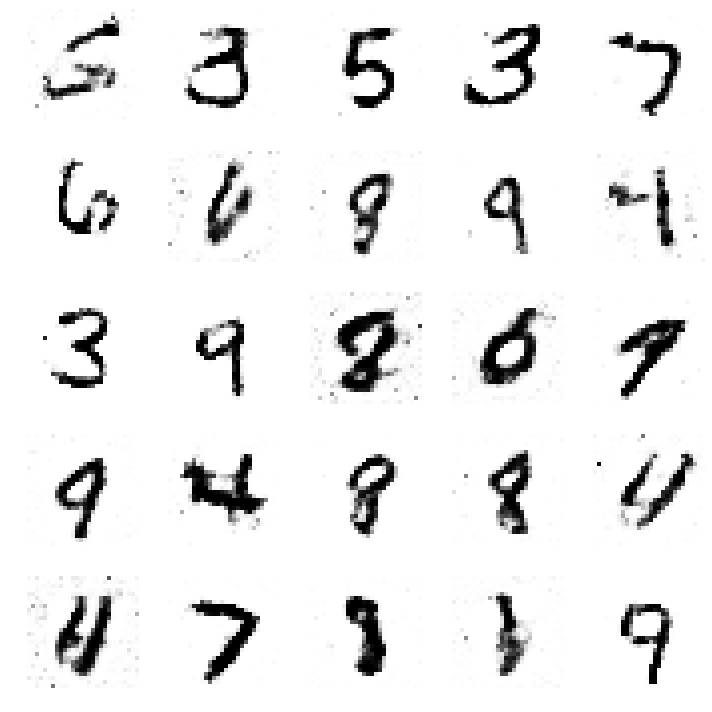

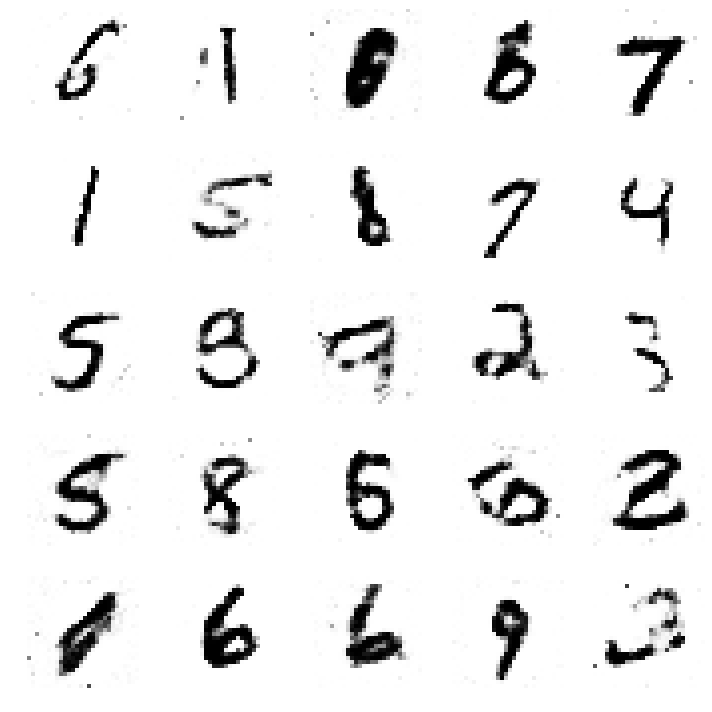

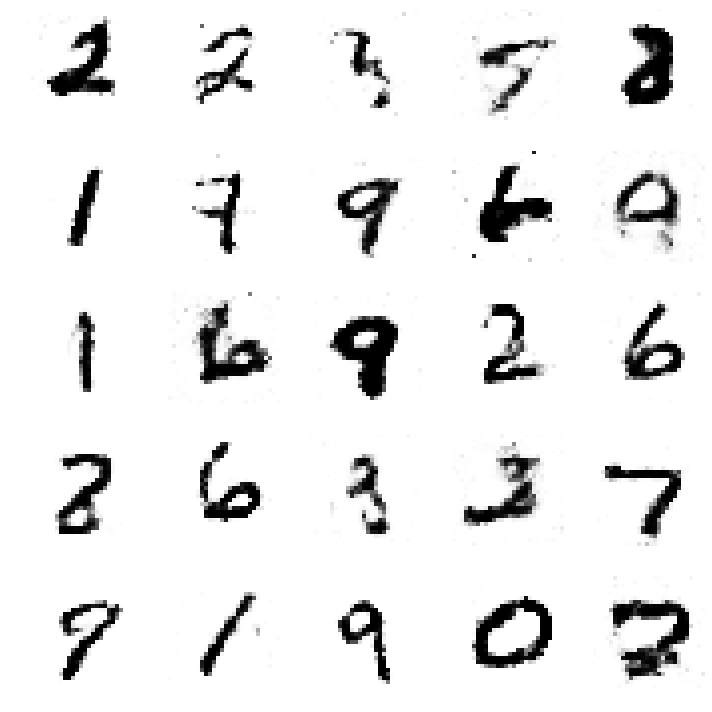

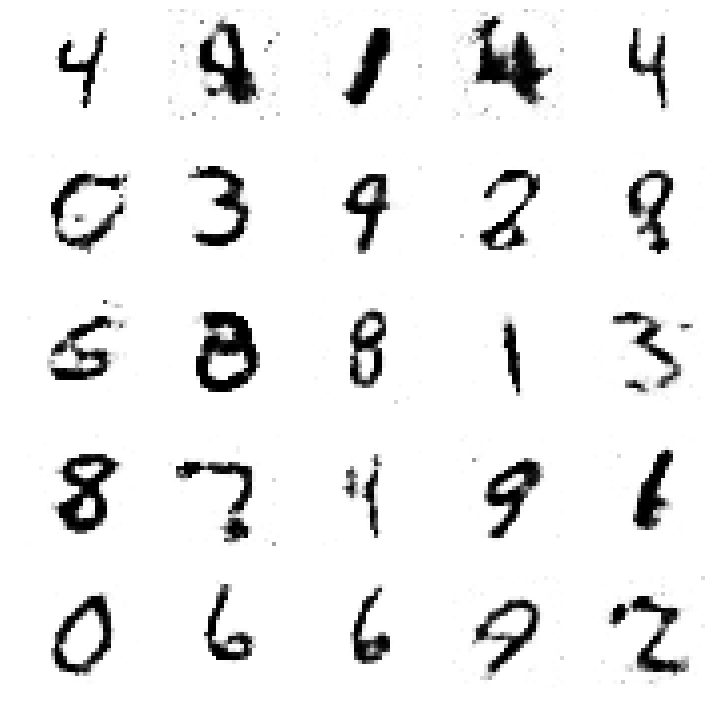

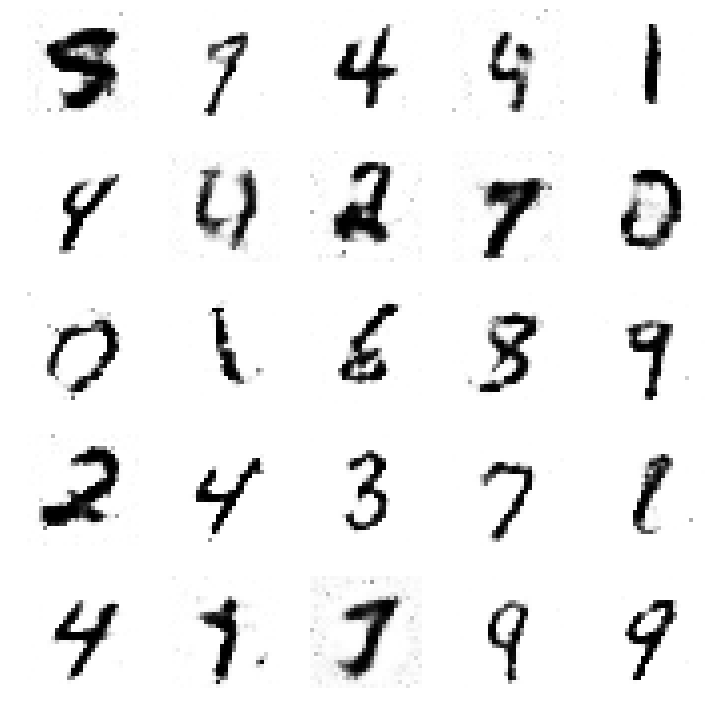

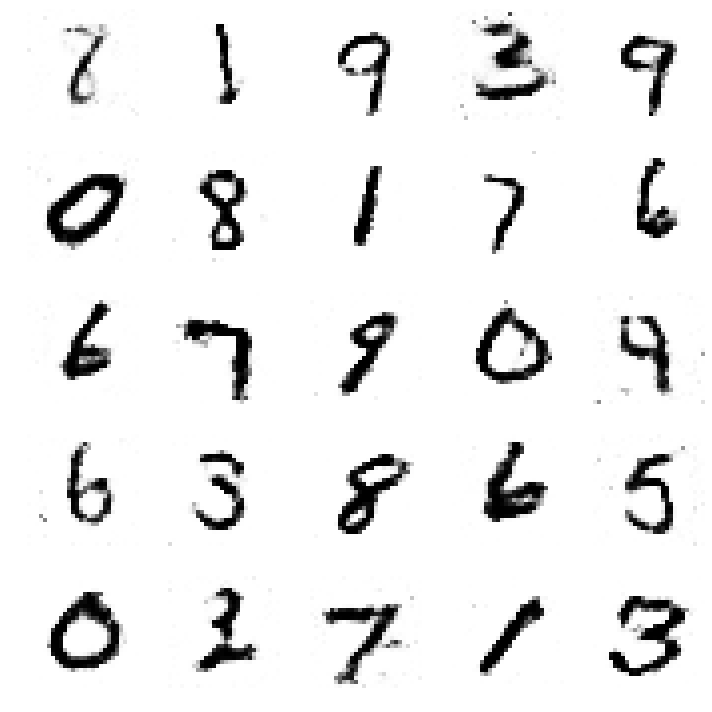

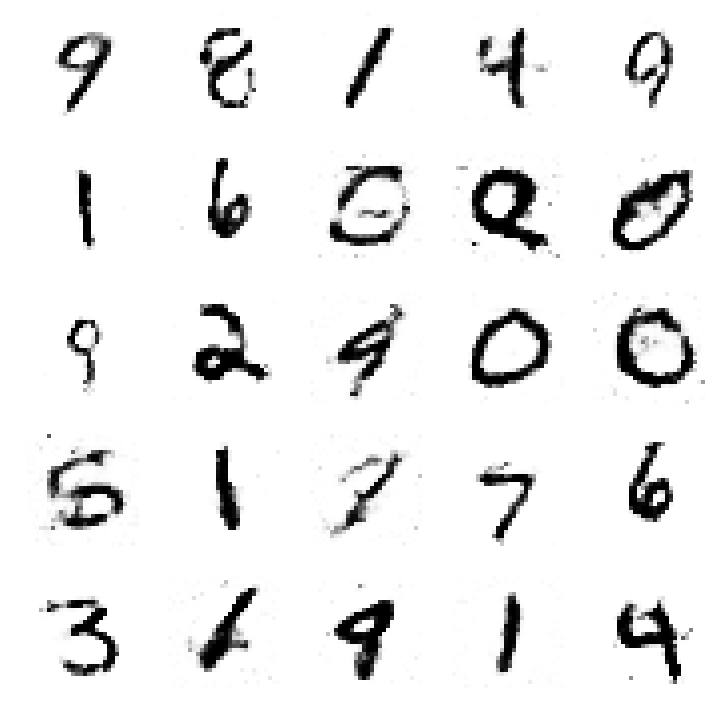

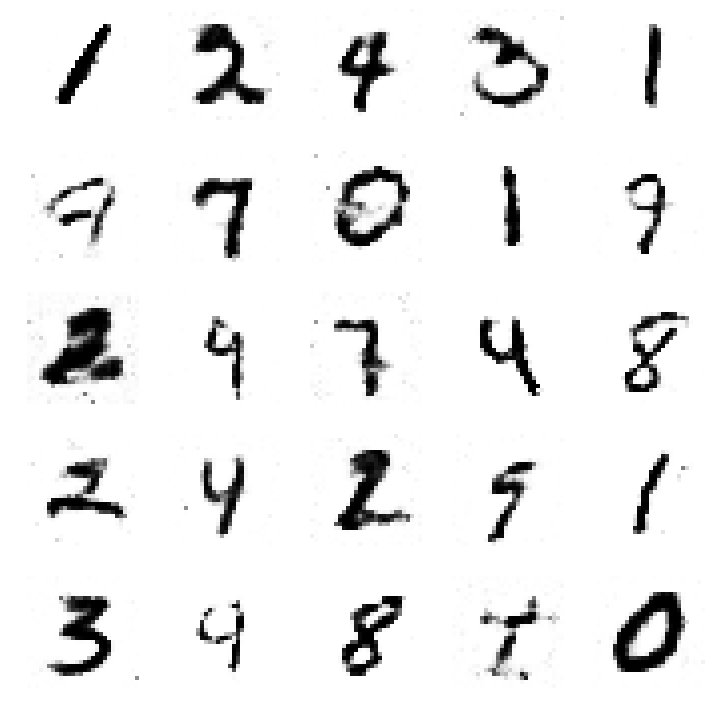

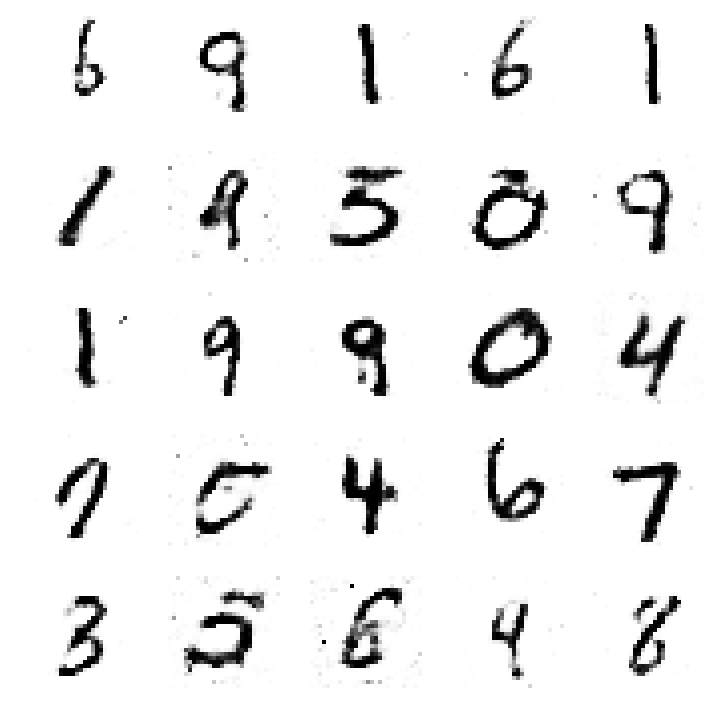

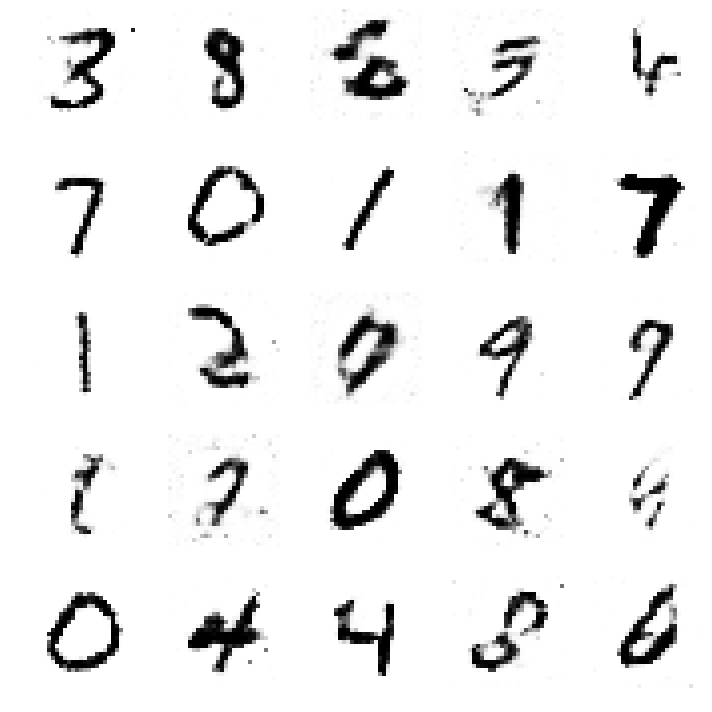

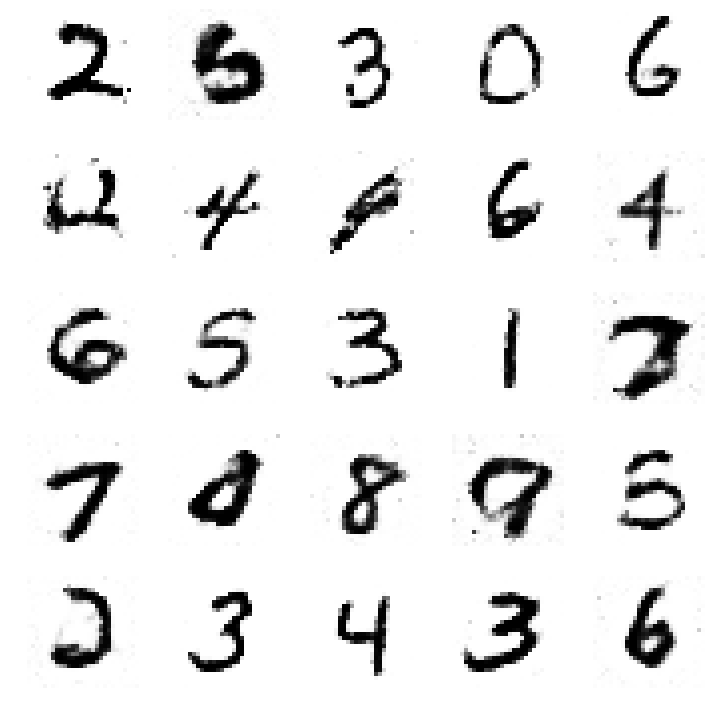

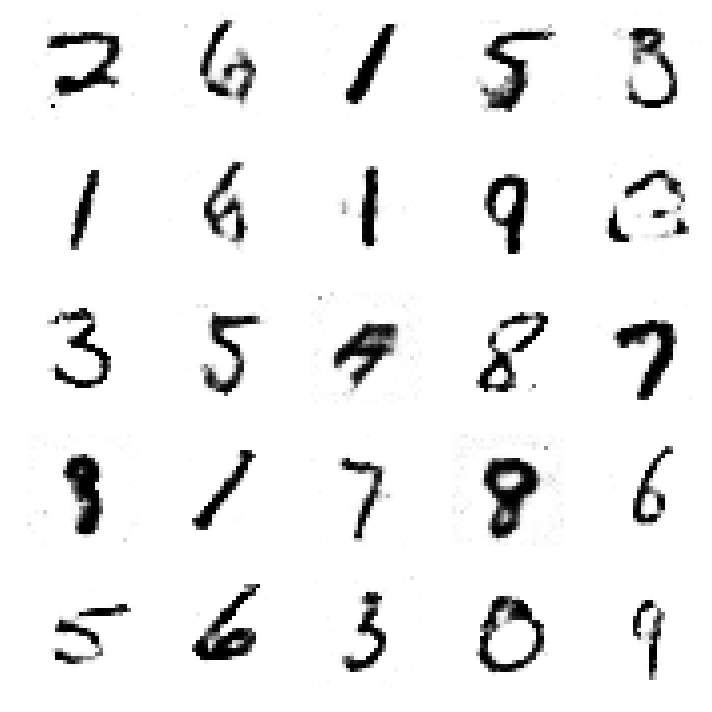

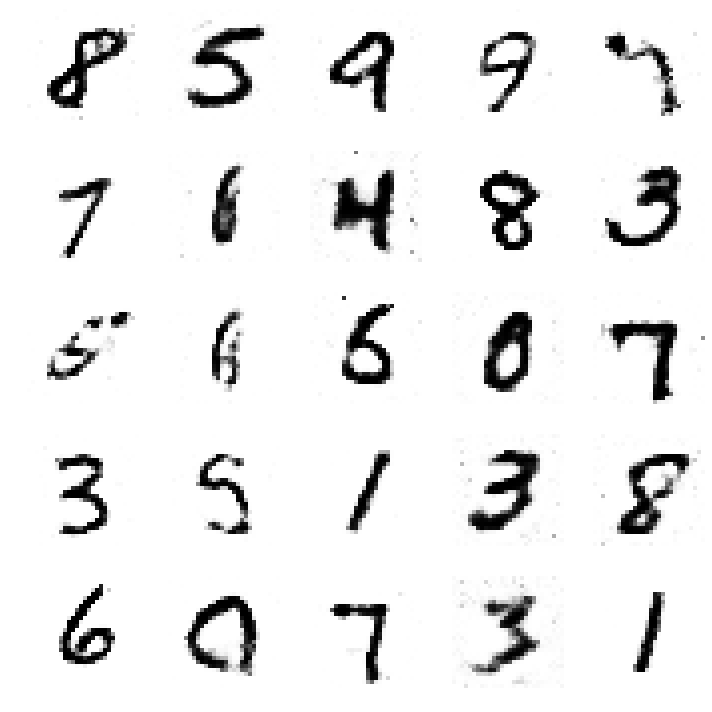

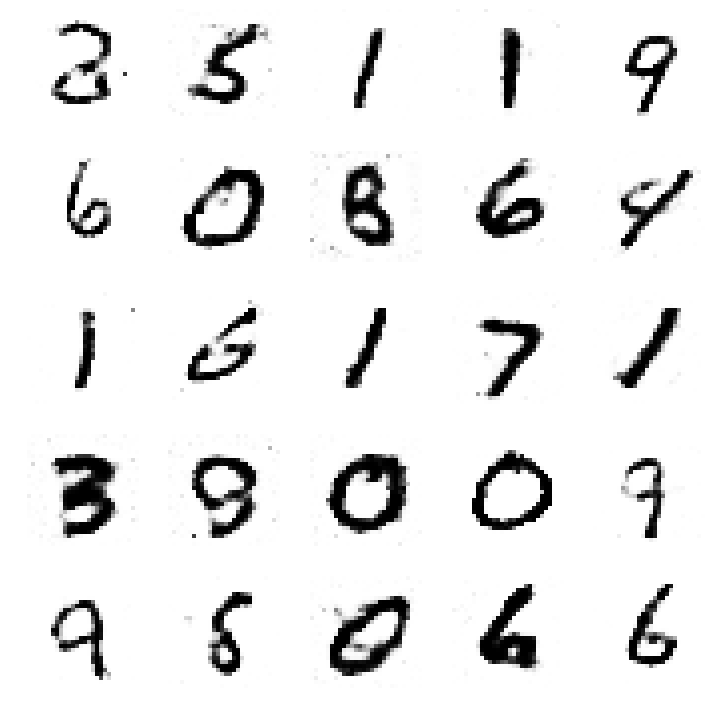

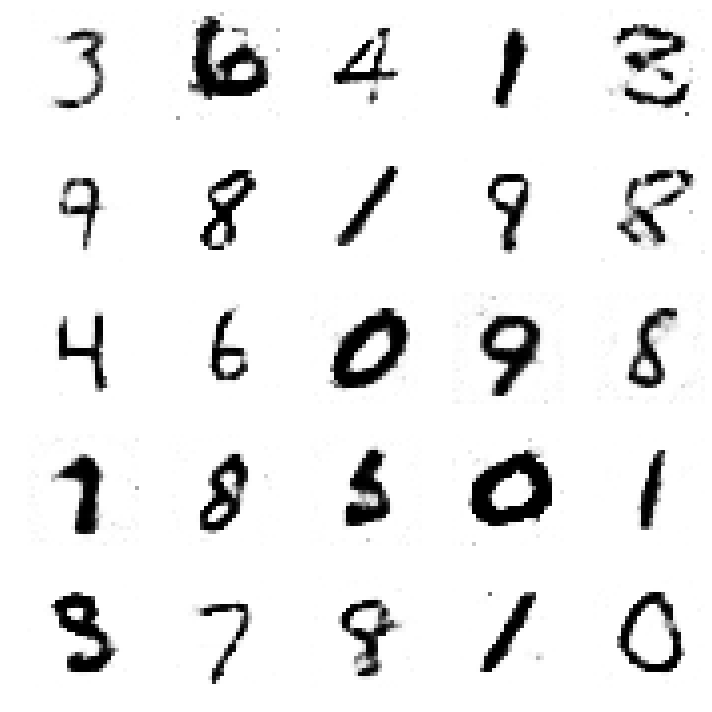

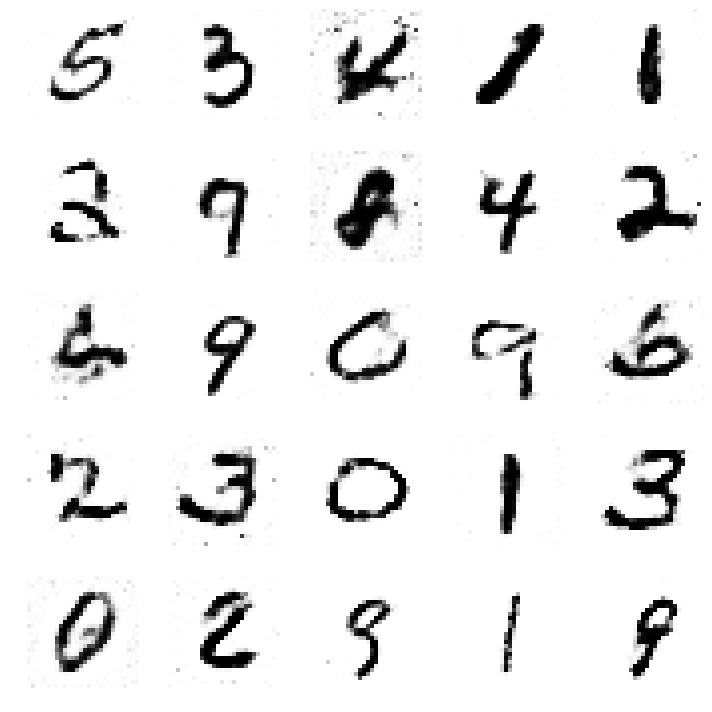

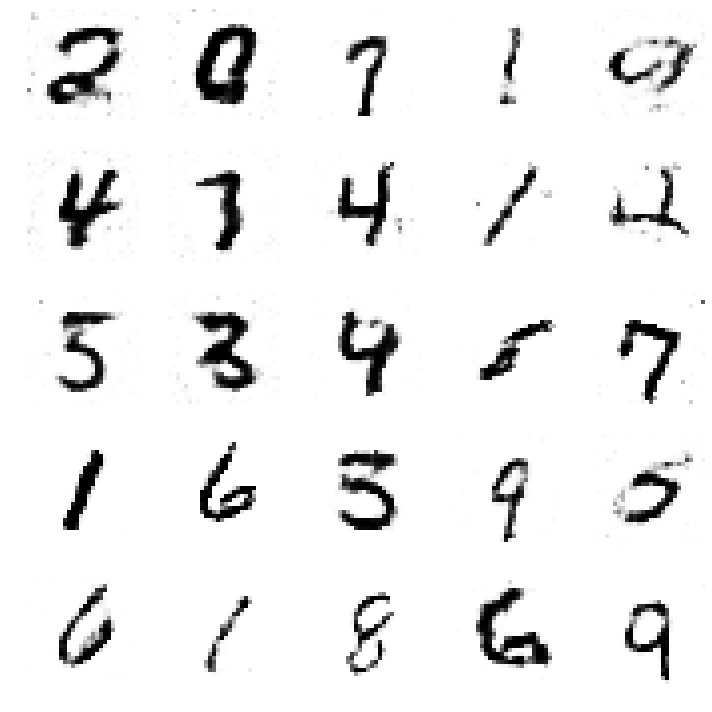

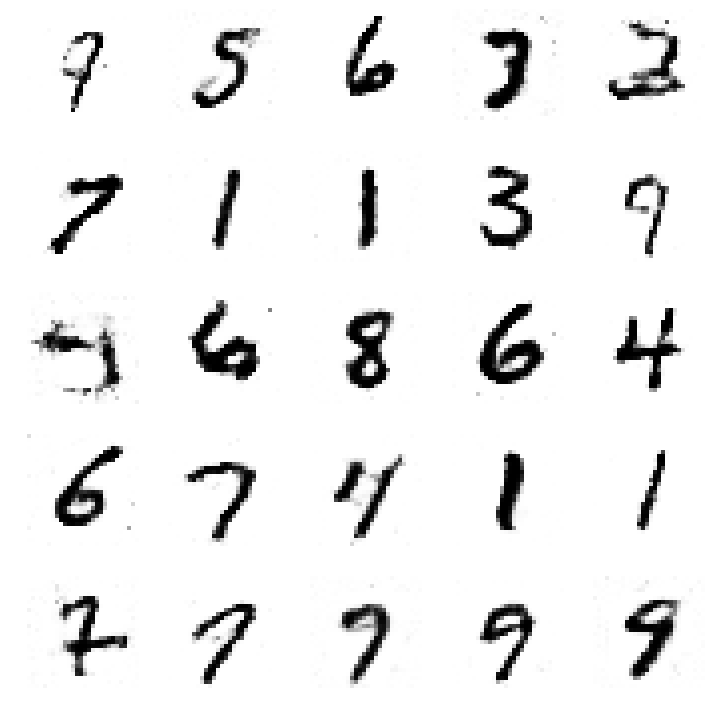

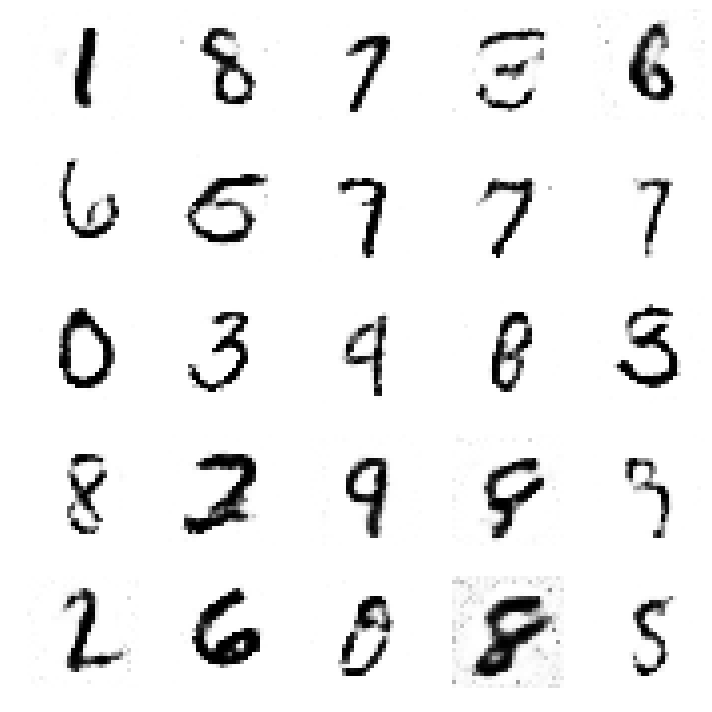

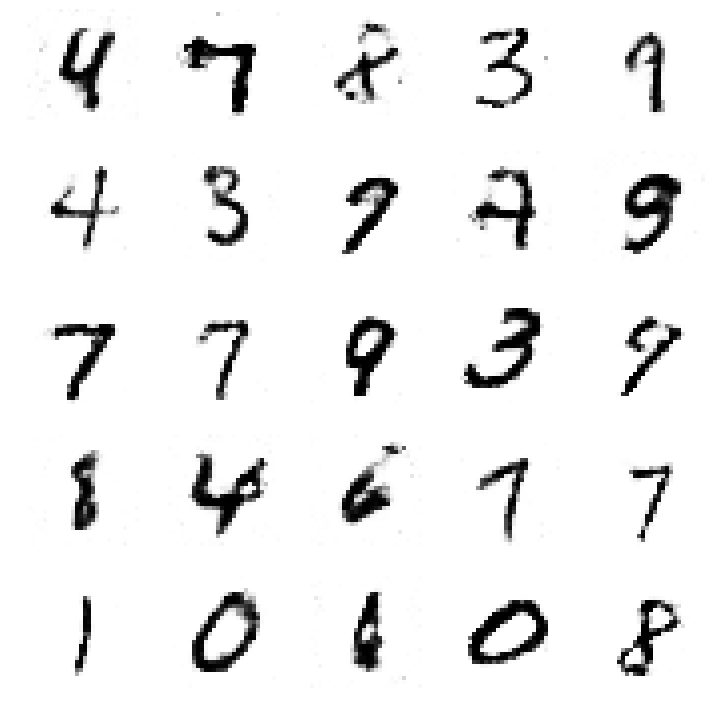

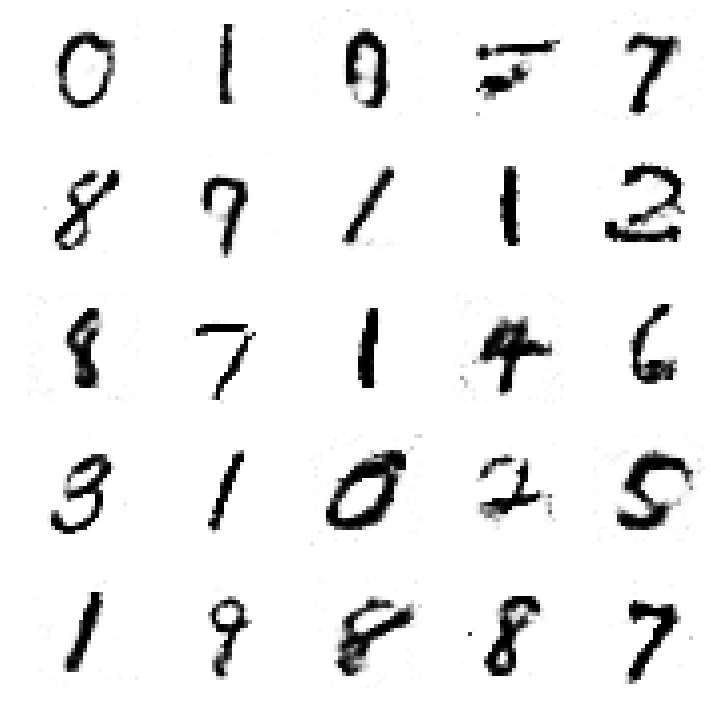

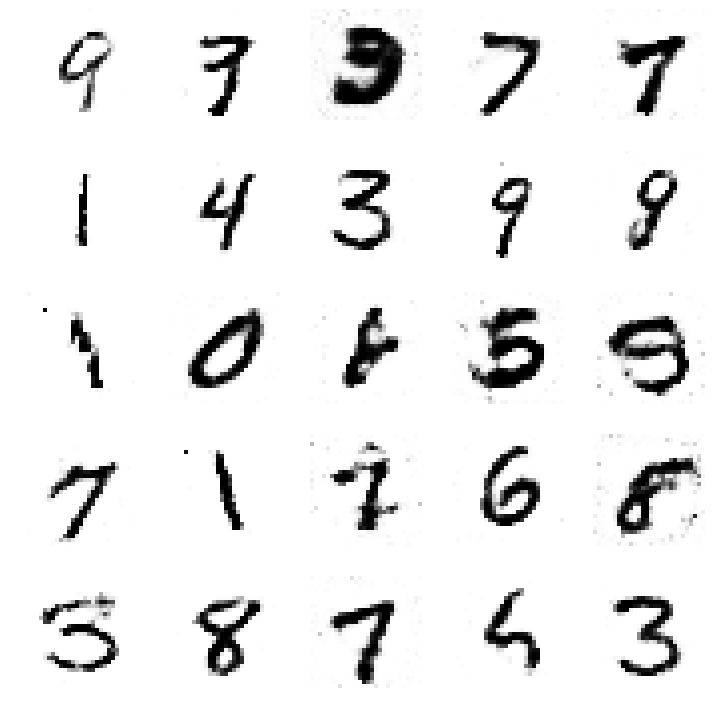

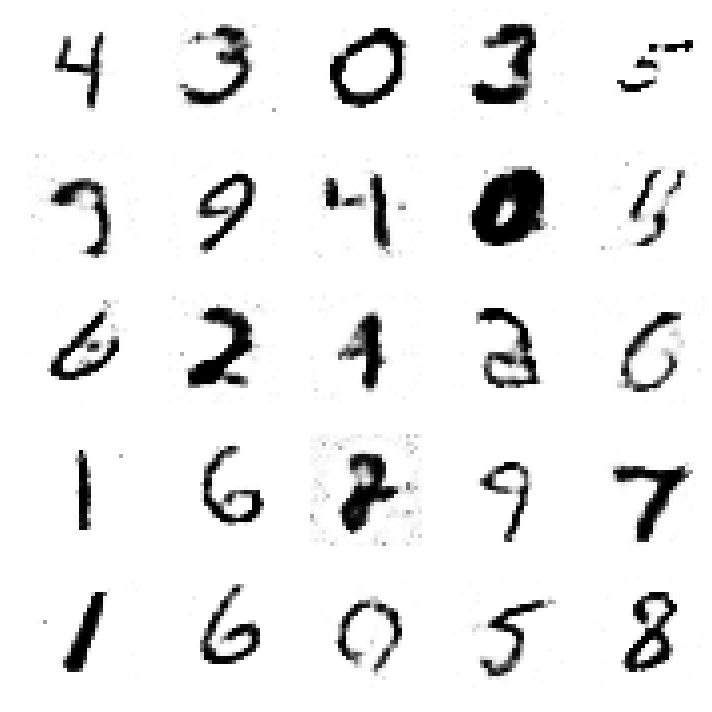

In [8]:
train_GAN(epochs=400, batch_size=128)